# Lab 11: Transcriptomics - GWAS + RNA-seq + GSEA Integration

## Teacher's Solution Notebook

This notebook contains fully solved exercises for the Transcriptomics laboratory session. The exercises demonstrate a real-world bioinformatics workflow integrating:

- **GWAS (Genome-Wide Association Studies)** data from public databases
- **RNA-seq** differential expression analysis
- **GSEA (Gene Set Enrichment Analysis)** for pathway analysis
- **Protein-Protein Interaction (PPI)** network analysis

**Learning Objectives:**
- Retrieve GWAS associations from the EBI GWAS Catalog API
- Extract and process gene sets from GWAS results
- Analyze RNA-seq differential expression data
- Perform Gene Set Enrichment Analysis (GSEA)
- Interpret GSEA results and identify leading edge genes
- Build and visualize protein interaction networks

---

## Laboratory Pipeline Overview

This laboratory follows an integrated multi-omics analysis pipeline:

1. **Exercise 1: Fetch GWAS Associations** - Retrieve genetic associations from the GWAS Catalog
2. **Exercise 2: Extract GWAS Genes** - Convert SNP associations to candidate gene sets
3. **Exercise 3: Load & Visualize RNA-seq Data** - Explore differential expression with volcano plots
4. **Exercise 4: Rank Genes for GSEA** - Prepare ranked gene lists for enrichment analysis
5. **Exercise 5: Run GWAS-GSEA Integration** - Test if GWAS genes are enriched in expression changes
6. **Exercise 6: Interpret GSEA Results** - Analyze enrichment scores and significance
7. **Exercise 7: Network Analysis** - Build PPI networks from leading edge genes

---

### Biological Context

**Why integrate GWAS and RNA-seq?**

GWAS identifies genetic variants (SNPs) associated with diseases or traits, but these variants often lie in non-coding regions, making it difficult to identify the causal genes. By integrating GWAS results with RNA-seq differential expression data, we can:

1. Test whether GWAS-implicated genes show altered expression in disease
2. Prioritize candidate genes for functional validation
3. Identify disease-relevant pathways and networks

In this lab, we'll analyze **Crohn's disease** as our case study - a chronic inflammatory bowel disease with a strong genetic component.

In [1]:
# Import required libraries
%matplotlib inline

# Data manipulation
import pandas as pd
import numpy as np
from typing import Set, Dict

# API and network
import requests
import networkx as nx

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pyvis.network import Network

# Gene Set Enrichment Analysis
import gseapy as gp

# Configure plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


---

## Exercise 1: Fetch GWAS Associations from the GWAS Catalog

**Background:**

The [GWAS Catalog](https://www.ebi.ac.uk/gwas/) is a curated collection of published genome-wide association studies. It provides a REST API to programmatically access association data, including:
- Variant identifiers (rsIDs)
- Association p-values
- Mapped genes near each variant

**Goals:**
1. Query the GWAS Catalog API for a specific disease trait
2. Filter associations by genome-wide significance (p < 5×10⁻⁸)
3. Extract SNP IDs, p-values, and mapped genes

**Key Concepts:**
- REST API usage for biological databases
- GWAS significance thresholds
- SNP-to-gene mapping

**API Documentation:** https://www.ebi.ac.uk/gwas/rest/docs/api

In [2]:
def fetch_gwas_associations(trait: str, pval_threshold: float = 5e-8) -> pd.DataFrame:
    """
    Retrieve real GWAS associations for a given trait from the GWAS Catalog API.
    
    Parameters:
    -----------
    trait : str
        Disease or phenotype name (e.g., "Crohn's disease")
    pval_threshold : float
        GWAS significance cutoff (default: 5e-8 for genome-wide significance)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with columns:
        - rsid: SNP identifier
        - pvalue: Association p-value
        - mapped_genes: Genes mapped to the variant
    
    Notes:
    ------
    The GWAS Catalog uses EFO (Experimental Factor Ontology) trait terms.
    Common traits: "Crohn's disease", "type 2 diabetes", "breast cancer"
    """
    url = "https://www.ebi.ac.uk/gwas/rest/api/associations"
    params = {"efoTrait": trait}
    headers = {"Accept": "application/json"}
    
    print(f"Querying GWAS Catalog for: {trait}")
    response = requests.get(url, params=params, headers=headers)
    response.raise_for_status()
    
    records = []
    data = response.json()["_embedded"]["associations"]
    
    for assoc in data:
        pval = assoc.get("pvalue", 1.0)
        if pval > pval_threshold:
            continue

        # Extract SNP id
        rsid = None
        try:
            allele_name = assoc['loci'][0]['strongestRiskAlleles'][0]['riskAlleleName']
            rsid = allele_name.split("-")[0]  # remove risk allele suffix
        except (IndexError, KeyError):
            rsid = None

        # Extract genes
        genes = []
        try:
            for g in assoc['loci'][0].get('authorReportedGenes', []):
                if 'geneName' in g and g['geneName']:
                    genes.append(g['geneName'])
        except (IndexError, KeyError):
            pass

        records.append({
            "rsid": rsid,
            "pvalue": pval,
            "mapped_genes": ",".join(genes)
        })

    df = pd.DataFrame(records)
    df = df.dropna(subset=['rsid'])
    return df

In [3]:
# Exercise 1: Fetch GWAS associations for Crohn's disease
print("=" * 60)
print("Exercise 1: Fetch GWAS Associations")
print("=" * 60)

# Query the GWAS Catalog
gwas_df = fetch_gwas_associations("Crohn's disease")

# Display results
print(f"\nGWAS Results Summary:")
print(f"  Total significant SNPs: {len(gwas_df)}")
print(f"  P-value range: {gwas_df['pvalue'].min():.2e} - {gwas_df['pvalue'].max():.2e}")

# Show first few associations
print("\nTop 10 associations by p-value:")
gwas_df.sort_values('pvalue').head(10)

Exercise 1: Fetch GWAS Associations
Querying GWAS Catalog for: Crohn's disease

GWAS Results Summary:
  Total significant SNPs: 13
  P-value range: 7.00e-28 - 5.00e-08

Top 10 associations by p-value:


,rsid,pvalue,mapped_genes
2,rs2138852,7.000000e-28,TAOK1
1,rs4654925,9.000000e-22,OTUD3
0,rs212388,3.000000e-14,TAGAP
7,rs10513137,6.000000e-12,ZBTB38
4,rs2074356,8.000000e-12,C12orf51
3,rs1128334,2.000000e-11,ETS1
8,rs13273123,1.000000e-09,PLAG1
9,rs3791675,2.000000e-09,EFEMP1
11,rs1182188,3.000000e-09,GNA12
5,rs12731740,3.000000e-09,"CD46,LOC148696"


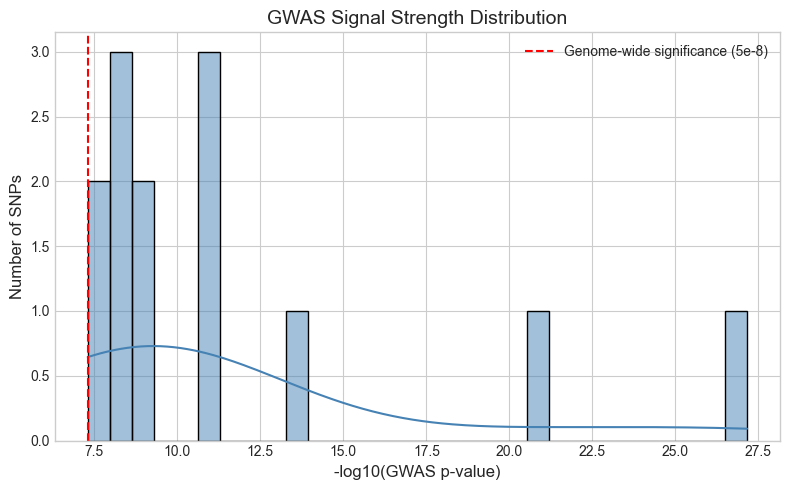

In [4]:
def plot_gwas_pvalues(gwas_df: pd.DataFrame):
    """
    Visualize the distribution of GWAS p-values.
    
    Parameters:
    -----------
    gwas_df : pd.DataFrame
        GWAS associations with 'pvalue' column
    """
    plt.figure(figsize=(8, 5))
    
    # Transform p-values to -log10 scale
    neg_log_p = -np.log10(gwas_df["pvalue"])
    
    sns.histplot(neg_log_p, bins=30, kde=True, color='steelblue')
    
    # Add significance threshold line
    plt.axvline(-np.log10(5e-8), color='red', linestyle='--', 
                label='Genome-wide significance (5e-8)')
    
    plt.xlabel("-log10(GWAS p-value)", fontsize=12)
    plt.ylabel("Number of SNPs", fontsize=12)
    plt.title("GWAS Signal Strength Distribution", fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Visualize GWAS p-value distribution
plot_gwas_pvalues(gwas_df)

---

## Exercise 2: Extract GWAS Candidate Genes

**Background:**

GWAS identifies genetic variants (SNPs), but for functional interpretation, we need to identify the genes these variants may affect. The GWAS Catalog provides "mapped genes" - genes that are:
- Located nearest to the variant
- Within the same linkage disequilibrium (LD) block
- Potentially regulated by the variant (eQTLs)

**Goals:**
1. Parse the mapped_genes field from GWAS results
2. Create a unique set of candidate genes
3. Understand the gene set size and composition

**Key Concepts:**
- SNP-to-gene mapping strategies
- Gene set construction for pathway analysis
- Data cleaning and parsing

In [5]:
def extract_gwas_genes(gwas_df: pd.DataFrame) -> Set[str]:
    """
    Convert GWAS SNP associations into a set of candidate genes.
    
    Parameters:
    -----------
    gwas_df : pd.DataFrame
        Output of fetch_gwas_associations() with 'mapped_genes' column
    
    Returns:
    --------
    Set[str]
        Unique gene symbols implicated by GWAS
    
    Notes:
    ------
    The mapped_genes field may contain multiple genes separated by commas.
    Some entries may contain special annotations like "intergenic" which
    should be handled appropriately.
    """
    genes = set()
    
    for gene_str in gwas_df["mapped_genes"].dropna():
        # Split by comma and clean whitespace
        for g in gene_str.split(","):
            gene = g.strip()
            # Skip empty strings and special annotations
            if gene and not gene.lower() in ['intergenic', 'na', 'none']:
                genes.add(gene)
    
    return genes

In [6]:
# Exercise 2: Extract candidate genes from GWAS results
print("=" * 60)
print("Exercise 2: Extract GWAS Candidate Genes")
print("=" * 60)

gwas_genes = extract_gwas_genes(gwas_df)

print(f"\nGWAS Gene Set Summary:")
print(f"  Total unique genes: {len(gwas_genes)}")
print(f"  SNPs per gene (avg): {len(gwas_df) / len(gwas_genes):.2f}")

# Display some example genes
print(f"\nExample GWAS genes (first 20):")
sorted_genes = sorted(gwas_genes)
print(", ".join(sorted_genes[:20]))

# Check for well-known Crohn's disease genes
known_cd_genes = {'NOD2', 'IL23R', 'ATG16L1', 'IRGM', 'IL10', 'CARD9'}
print(f"Found genes: {gwas_genes}")
print(f"Known genes: {known_cd_genes}")
found_known = known_cd_genes & gwas_genes
print(f"\nKnown Crohn's disease genes found: {found_known if found_known else 'None in this query'}") 


Exercise 2: Extract GWAS Candidate Genes

GWAS Gene Set Summary:
  Total unique genes: 14
  SNPs per gene (avg): 0.93

Example GWAS genes (first 20):
C12orf51, CD46, CDK6, EFEMP1, ETS1, GNA12, HLA-B, HMGA1, LOC148696, OTUD3, PLAG1, TAGAP, TAOK1, ZBTB38
Found genes: {'HMGA1', 'CDK6', 'ETS1', 'TAOK1', 'TAGAP', 'LOC148696', 'EFEMP1', 'GNA12', 'HLA-B', 'PLAG1', 'ZBTB38', 'OTUD3', 'CD46', 'C12orf51'}
Known genes: {'IL10', 'CARD9', 'ATG16L1', 'NOD2', 'IRGM', 'IL23R'}

Known Crohn's disease genes found: None in this query


---

## Exercise 3: Load and Visualize RNA-seq Differential Expression Data

**Background:**

RNA-seq measures gene expression levels across the transcriptome. Differential expression analysis compares expression between conditions (e.g., disease vs. healthy) to identify genes with altered expression.

Key metrics from differential expression analysis:
- **logFC (log₂ Fold Change)**: Magnitude and direction of expression change
- **p-value**: Statistical significance of the change

**Volcano plots** are a standard visualization that shows both significance (-log₁₀ p-value on y-axis) and effect size (logFC on x-axis).

**Goals:**
1. Load RNA-seq differential expression results
2. Create static and interactive volcano plots
3. Identify significantly differentially expressed genes

**Key Concepts:**
- Differential expression analysis interpretation
- Volcano plot visualization
- Multiple testing correction

In [7]:
# First, let's create synthetic RNA-seq data for demonstration
# In a real analysis, you would load actual experimental data

def generate_synthetic_rnaseq_data(n_genes: int = 5000, 
                                   gwas_genes: Set[str] = None,
                                   enrichment_strength: float = 0.3) -> pd.DataFrame:
    """
    Generate synthetic RNA-seq differential expression data.
    
    Parameters:
    -----------
    n_genes : int
        Number of genes to simulate
    gwas_genes : Set[str]
        GWAS genes to include (will have slightly elevated effect sizes)
    enrichment_strength : float
        How much to bias GWAS genes toward differential expression
    
    Returns:
    --------
    pd.DataFrame
        Simulated DE results with gene, logFC, pvalue columns
    """
    np.random.seed(42)
    
    # Generate random gene names
    genes = [f"GENE{i:04d}" for i in range(n_genes)]
    
    # Add GWAS genes if provided
    if gwas_genes:
        gwas_list = list(gwas_genes)
        # Replace some random genes with GWAS genes
        for i, gwas_gene in enumerate(gwas_list[:min(len(gwas_list), 200)]):
            genes[i] = gwas_gene
    
    # Generate logFC values (normal distribution)
    logfc = np.random.normal(0, 1, n_genes)
    
    # Bias GWAS genes toward larger effect sizes
    if gwas_genes:
        for i, gene in enumerate(genes):
            if gene in gwas_genes:
                # Add enrichment bias
                logfc[i] += np.random.choice([-1, 1]) * enrichment_strength * np.abs(np.random.normal(1, 0.5))
    
    # Generate p-values (related to effect size + noise)
    # Larger effects tend to have smaller p-values
    noise = np.random.exponential(0.5, n_genes)
    pvalues = 10 ** (-np.abs(logfc) * 2 - noise + np.random.normal(0, 1, n_genes))
    pvalues = np.clip(pvalues, 1e-300, 1)
    
    df = pd.DataFrame({
        'gene': genes,
        'logFC': logfc,
        'pvalue': pvalues
    })
    
    return df


def load_rnaseq_results(filepath: str = None, 
                        gwas_genes: Set[str] = None) -> pd.DataFrame:
    """
    Load RNA-seq differential expression results.
    
    Parameters:
    -----------
    filepath : str
        Path to CSV file with columns: gene, logFC, pvalue
        If None, generates synthetic data
    gwas_genes : Set[str]
        GWAS genes for synthetic data generation
    
    Returns:
    --------
    pd.DataFrame
        DE results indexed by gene
    """
    if filepath:
        df = pd.read_csv(filepath)
    else:
        # Generate synthetic data for demonstration
        df = generate_synthetic_rnaseq_data(n_genes=5000, gwas_genes=gwas_genes)
    
    df = df.set_index("gene")
    return df

In [8]:
# Exercise 3: Load RNA-seq data and create volcano plot
print("=" * 60)
print("Exercise 3: Load and Visualize RNA-seq Data")
print("=" * 60)

# Load/generate RNA-seq data
de_df = load_rnaseq_results(gwas_genes=gwas_genes)

print(f"\nRNA-seq Data Summary:")
print(f"  Total genes: {len(de_df)}")
print(f"  logFC range: [{de_df['logFC'].min():.2f}, {de_df['logFC'].max():.2f}]")
print(f"  Significant genes (p < 0.05): {(de_df['pvalue'] < 0.05).sum()}")
print(f"  Highly significant (p < 0.001): {(de_df['pvalue'] < 0.001).sum()}")

# Display summary statistics
de_df.describe()

Exercise 3: Load and Visualize RNA-seq Data

RNA-seq Data Summary:
  Total genes: 5000
  logFC range: [-3.24, 3.93]
  Significant genes (p < 0.05): 3304
  Highly significant (p < 0.001): 1347


,logFC,pvalue
count,5000.000000,5.000000e+03
mean,0.005929,1.630914e-01
std,0.997050,3.095734e-01
min,-3.241267,1.692823e-09
25%,-0.658767,7.718789e-04
50%,0.014039,1.127878e-02
75%,0.668419,1.195946e-01
max,3.926238,1.000000e+00


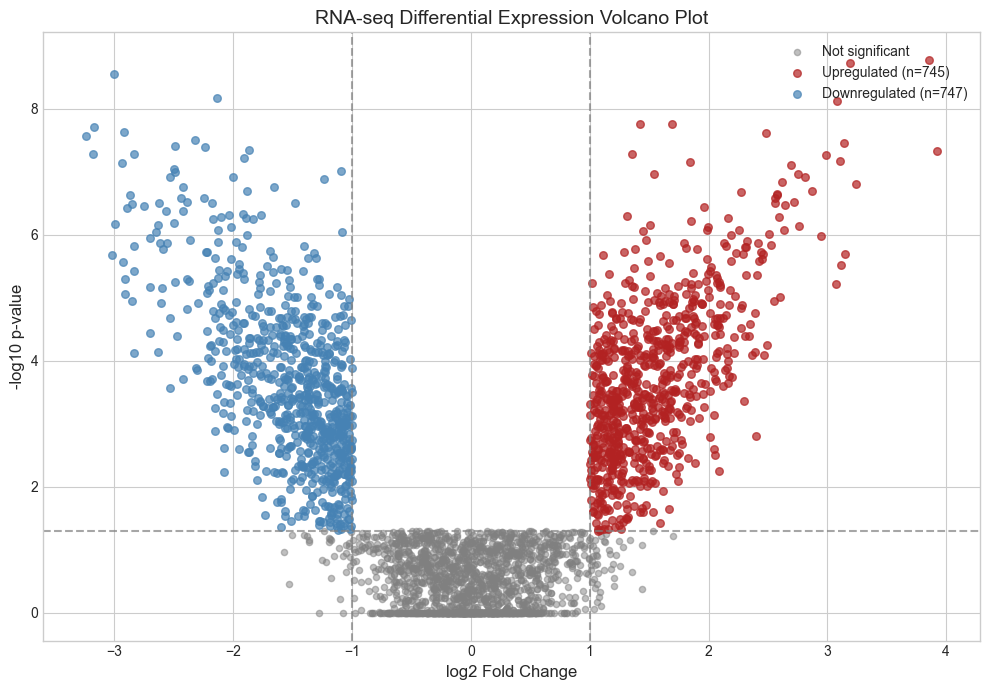

In [9]:
def plot_volcano(de_df: pd.DataFrame, pval_cutoff: float = 0.05, logfc_cutoff: float = 1.0):
    """
    Create a volcano plot of RNA-seq differential expression.
    
    Parameters:
    -----------
    de_df : pd.DataFrame
        RNA-seq DE results with logFC and pvalue columns
    pval_cutoff : float
        Significance threshold for coloring
    logfc_cutoff : float
        Effect size threshold for coloring
    """
    plt.figure(figsize=(10, 7))
    
    # Calculate -log10(pvalue)
    neg_log_p = -np.log10(de_df["pvalue"])
    
    # Define categories
    sig = de_df["pvalue"] < pval_cutoff
    up = (de_df["logFC"] > logfc_cutoff) & sig
    down = (de_df["logFC"] < -logfc_cutoff) & sig
    
    # Plot non-significant points
    plt.scatter(
        de_df.loc[~sig, "logFC"],
        neg_log_p[~sig],
        c='gray', alpha=0.5, s=20, label=f'Not significant'
    )
    
    # Plot upregulated genes
    plt.scatter(
        de_df.loc[up, "logFC"],
        neg_log_p[up],
        c='firebrick', alpha=0.7, s=30, label=f'Upregulated (n={up.sum()})'
    )
    
    # Plot downregulated genes
    plt.scatter(
        de_df.loc[down, "logFC"],
        neg_log_p[down],
        c='steelblue', alpha=0.7, s=30, label=f'Downregulated (n={down.sum()})'
    )
    
    # Add threshold lines
    plt.axhline(-np.log10(pval_cutoff), linestyle="--", color='gray', alpha=0.7)
    plt.axvline(logfc_cutoff, linestyle="--", color='gray', alpha=0.7)
    plt.axvline(-logfc_cutoff, linestyle="--", color='gray', alpha=0.7)
    
    plt.xlabel("log2 Fold Change", fontsize=12)
    plt.ylabel("-log10 p-value", fontsize=12)
    plt.title("RNA-seq Differential Expression Volcano Plot", fontsize=14)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Create static volcano plot
plot_volcano(de_df)

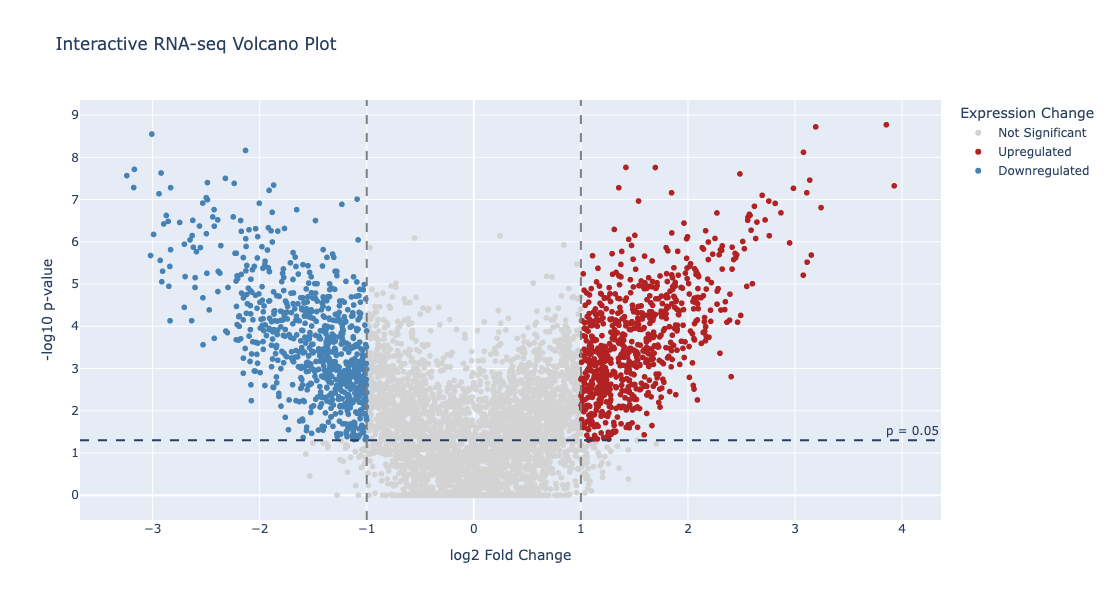

In [10]:
def interactive_volcano_plot(de_df: pd.DataFrame, pval_cutoff: float = 0.05, logfc_cutoff: float = 1.0):
    """
    Create an interactive volcano plot for RNA-seq results using Plotly.
    
    Parameters:
    -----------
    de_df : pd.DataFrame
        RNA-seq DE results with logFC and pvalue columns
    pval_cutoff : float
        Significance threshold
    logfc_cutoff : float
        Effect size threshold for coloring
    
    Returns:
    --------
    Interactive Plotly figure
    """
    df = de_df.copy()
    df["neg_log10_p"] = -np.log10(df["pvalue"])
    df["significant"] = df["pvalue"] < pval_cutoff
    df["gene_name"] = df.index
    
    # Assign colors based on significance and direction (with logFC cutoff)
    df["category"] = "Not Significant"
    df.loc[(df["significant"]) & (df["logFC"] > logfc_cutoff), "category"] = "Upregulated"
    df.loc[(df["significant"]) & (df["logFC"] < -logfc_cutoff), "category"] = "Downregulated"
    
    color_map = {
        "Not Significant": "lightgray",
        "Upregulated": "firebrick",
        "Downregulated": "steelblue"
    }
    
    fig = px.scatter(
        df,
        x="logFC",
        y="neg_log10_p",
        color="category",
        color_discrete_map=color_map,
        hover_name="gene_name",
        hover_data={"logFC": ":.3f", "pvalue": ":.2e", "neg_log10_p": False, "category": False},
        title="Interactive RNA-seq Volcano Plot",
        labels={
            "logFC": "log2 Fold Change",
            "neg_log10_p": "-log10 p-value"
        }
    )
    
    # Add significance threshold lines
    fig.add_hline(y=-np.log10(pval_cutoff), line_dash="dash", 
                  annotation_text=f"p = {pval_cutoff}")
    fig.add_vline(x=logfc_cutoff, line_dash="dash", line_color="gray")
    fig.add_vline(x=-logfc_cutoff, line_dash="dash", line_color="gray")
    
    fig.update_layout(
        width=800,
        height=600,
        legend_title_text="Expression Change"
    )
    
    fig.show()

# Create interactive volcano plot
interactive_volcano_plot(de_df)

---

## Exercise 4: Rank Genes for GSEA

**Background:**

Gene Set Enrichment Analysis (GSEA) is a powerful method to determine whether predefined gene sets show statistically significant differences between conditions. Unlike over-representation analysis (which uses a cutoff), GSEA uses a **ranked list** of all genes.

**Ranking metrics:**
- **logFC**: Simple and interpretable
- **Signed p-value**: -log₁₀(p) × sign(logFC) - incorporates significance
- **t-statistic**: If available from DE analysis

**Goals:**
1. Create a ranked gene list based on expression changes
2. Visualize where GWAS genes appear in the ranking
3. Understand the pre-ranked GSEA approach

**Key Concepts:**
- Gene ranking strategies
- Pre-ranked GSEA
- Visualizing gene positions in ranked lists

In [ ]:
def rank_genes_for_gsea(de_df: pd.DataFrame, 
                        ranking_metric: str = "logFC") -> pd.Series:
    """
    Create a ranked gene list for GSEA.
    
    Parameters:
    -----------
    de_df : pd.DataFrame
        RNA-seq DE results with logFC and optionally pvalue columns
    ranking_metric : str
        Column to use for ranking. Options:
        - "logFC": Use log fold change directly
        - "signed_pvalue": Use -log10(p) * sign(logFC)
    
    Returns:
    --------
    pd.Series
        Gene rankings (index = gene, value = score)
        Sorted from highest to lowest
    
    Notes:
    ------
    For GSEA, genes are ranked from most upregulated to most downregulated.
    Positive scores indicate upregulation, negative indicate downregulation.
    """
    if ranking_metric == "signed_pvalue":
        # Create signed p-value metric
        ranked = -np.log10(de_df["pvalue"]) * np.sign(de_df["logFC"])
    else:
        ranked = de_df[ranking_metric]
    
    ranked = ranked.sort_values(ascending=False)
    ranked = ranked.dropna()
    
    return ranked

In [16]:
def compute_running_es(ranked_genes: pd.Series, gene_set: set, p: float = 1.0):
    N = len(ranked_genes)
    hits = ranked_genes.index.isin(gene_set)
    
    # Weights
    weights = np.abs(ranked_genes.values) ** p
    norm_hit = np.sum(weights[hits])
    norm_miss = N - np.sum(hits)
    
    running_es = []
    es = 0.0
    
    for is_hit, w in zip(hits, weights):
        if is_hit:
            es += w / norm_hit
        else:
            es -= 1 / norm_miss
        running_es.append(es)
    
    return np.array(running_es)
    

In [17]:
# Exercise 4: Rank genes for GSEA
print("=" * 60)
print("Exercise 4: Rank Genes for GSEA")
print("=" * 60)

# Create ranked gene list
ranked_genes = rank_genes_for_gsea(de_df, ranking_metric="logFC")

print(f"\nRanked Gene List Summary:")
print(f"  Total ranked genes: {len(ranked_genes)}")
print(f"  Score range: [{ranked_genes.min():.3f}, {ranked_genes.max():.3f}]")

print("\nTop 10 upregulated genes:")
print(ranked_genes.head(10).to_frame('logFC'))

print("\nTop 10 downregulated genes:")
print(ranked_genes.tail(10).to_frame('logFC'))

Exercise 4: Rank Genes for GSEA

Ranked Gene List Summary:
  Total ranked genes: 5000
  Score range: [-3.241, 3.926]

Top 10 upregulated genes:
             logFC
gene              
GENE2895  3.926238
GENE0209  3.852731
GENE3716  3.243093
GENE1615  3.193108
GENE3982  3.152057
GENE1957  3.137749
GENE4997  3.112910
GENE2305  3.109919
GENE0478  3.078881
GENE4870  3.076860

Top 10 downregulated genes:
             logFC
gene              
GENE4635 -2.914256
GENE1591 -2.921350
GENE3454 -2.929449
GENE1971 -2.940389
GENE2947 -2.991136
GENE4198 -3.007632
GENE2024 -3.019512
GENE4725 -3.170426
GENE4779 -3.176704
GENE0262 -3.241267


GWAS genes found in ranked list: 14 / 14


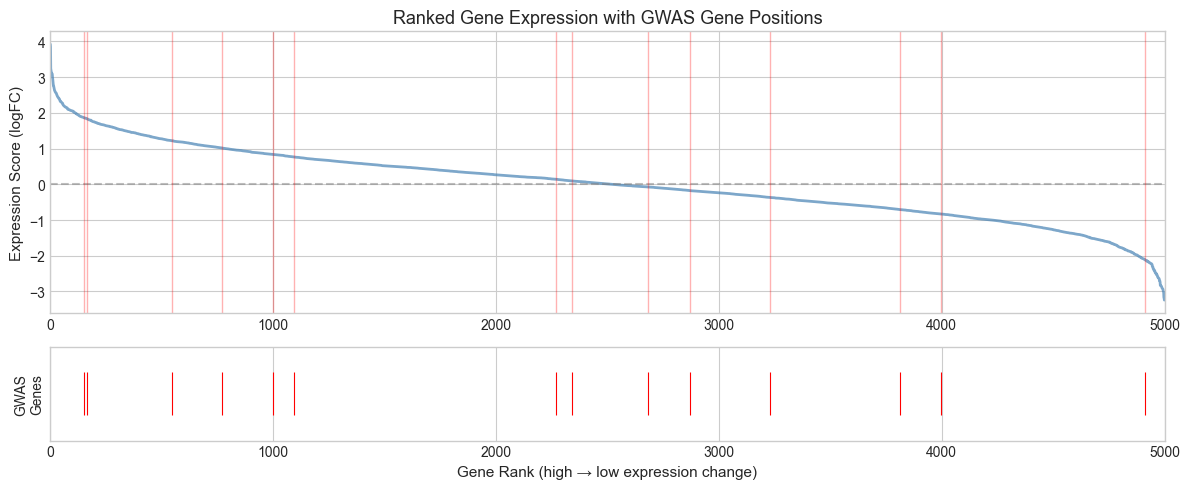

In [31]:
def plot_gwas_gene_ranking(ranked_genes: pd.Series, gwas_genes: Set[str]):
    """
    Visualize where GWAS genes appear in the ranked expression list.
    
    This "barcode plot" shows the distribution of GWAS genes across
    the ranked list. If GWAS genes are enriched at one end, it suggests
    they tend to be up- or down-regulated in disease.
    
    Parameters:
    -----------
    ranked_genes : pd.Series
        Ranked RNA-seq gene scores
    gwas_genes : Set[str]
        GWAS-associated genes
    """
    # Find positions of GWAS genes in ranked list
    positions = [
        i for i, gene in enumerate(ranked_genes.index)
        if gene in gwas_genes
    ]
    
    print(f"GWAS genes found in ranked list: {len(positions)} / {len(gwas_genes)}")
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 5), 
                             gridspec_kw={'height_ratios': [3, 1]})
    
    # Top plot: ranked scores
    ax1 = axes[0]
    ax1.plot(range(len(ranked_genes)), ranked_genes.values, 
             color='steelblue', alpha=0.7, linewidth=2)
    ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)
    ax1.set_ylabel('Expression Score (logFC)', fontsize=11)
    ax1.set_title('Ranked Gene Expression with GWAS Gene Positions', fontsize=13)
    ax1.set_xlim(0, len(ranked_genes))
    
    # Highlight GWAS genes
    for pos in positions:
        ax1.axvline(pos, color='red', alpha=0.3, linewidth=1)
    
    # Bottom plot: barcode
    ax2 = axes[1]
    ax2.eventplot(positions, orientation='horizontal', colors='red', linewidths=0.8)
    ax2.set_xlabel('Gene Rank (high → low expression change)', fontsize=11)
    ax2.set_yticks([])
    ax2.set_xlim(0, len(ranked_genes))
    ax2.set_ylabel('GWAS\nGenes', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Visualize GWAS gene positions
plot_gwas_gene_ranking(ranked_genes, gwas_genes)

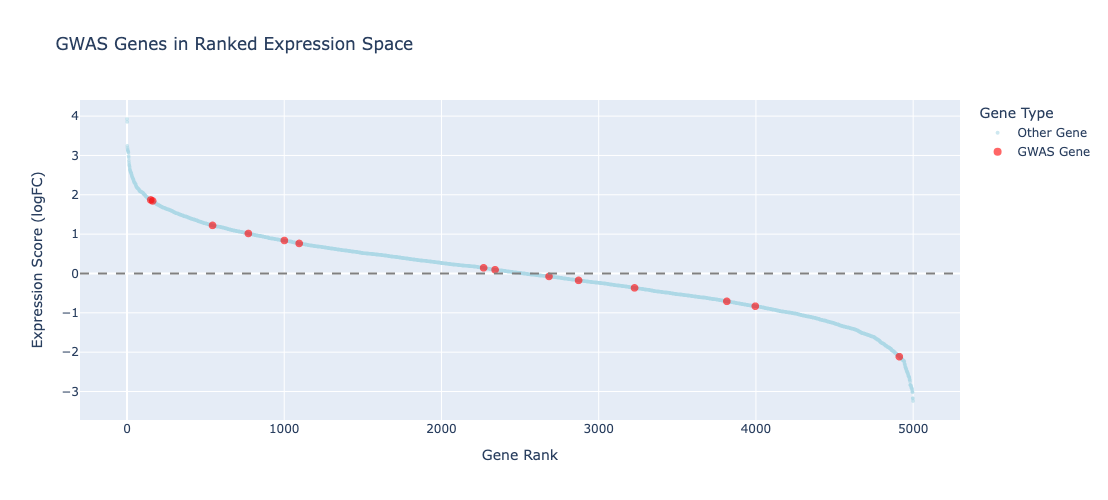

In [32]:
def interactive_gwas_ranking_plot(ranked_genes: pd.Series, gwas_genes: Set[str]):
    """
    Visualize GWAS gene positions in ranked RNA-seq results interactively.
    
    Parameters:
    -----------
    ranked_genes : pd.Series
        Ranked gene list
    gwas_genes : Set[str]
        GWAS-associated genes
    
    Returns:
    --------
    Interactive Plotly figure
    """
    df = pd.DataFrame({
        "rank": range(len(ranked_genes)),
        "gene": ranked_genes.index,
        "score": ranked_genes.values
    })
    
    df["GWAS"] = df["gene"].isin(gwas_genes)
    df["gene_type"] = df["GWAS"].map({True: "GWAS Gene", False: "Other Gene"})
    
    fig = px.scatter(
        df,
        x="rank",
        y="score",
        color="gene_type",
        color_discrete_map={"GWAS Gene": "red", "Other Gene": "lightblue"},
        hover_name="gene",
        hover_data={"score": ":.3f", "rank": True, "gene_type": False},
        title="GWAS Genes in Ranked Expression Space",
        labels={"rank": "Gene Rank", "score": "Expression Score (logFC)"},
        opacity=0.6
    )
    
    # Update marker sizes
    fig.update_traces(
        marker=dict(size=8),
        selector=dict(name="GWAS Gene")
    )
    fig.update_traces(
        marker=dict(size=4),
        selector=dict(name="Other Gene")
    )
    
    fig.add_hline(y=0, line_dash="dash", line_color="gray")
    
    fig.update_layout(
        width=900,
        height=500,
        legend_title_text="Gene Type"
    )
    
    fig.show()

# Create interactive ranking plot
interactive_gwas_ranking_plot(ranked_genes, gwas_genes)

---

## Exercise 5: Run GWAS-GSEA Integration Analysis

**Background:**

Now we perform the key integration step: testing whether GWAS-associated genes are enriched in the RNA-seq expression changes. GSEA works by:

1. Walking down the ranked gene list
2. Increasing a running score when encountering a gene in the gene set
3. Decreasing the score for genes not in the set
4. The **Enrichment Score (ES)** is the maximum deviation from zero
5. Significance is determined by permutation testing

**Interpretation:**
- **Positive NES**: Gene set enriched at the TOP of the list (upregulated)
- **Negative NES**: Gene set enriched at the BOTTOM of the list (downregulated)
- **NES near 0**: No significant enrichment

**Goals:**
1. Run pre-ranked GSEA with GWAS gene set
2. Visualize the enrichment curve
3. Interpret the Normalized Enrichment Score (NES)

**Key Concepts:**
- GSEA algorithm mechanics
- Permutation testing
- Enrichment score interpretation

In [33]:
def run_gwas_gsea(ranked_genes: pd.Series,
                  gwas_genes: Set[str],
                  n_permutations: int = 1000) -> Dict:
    """
    Test whether GWAS-associated genes are enriched in RNA-seq changes.
    
    Parameters:
    -----------
    ranked_genes : pd.Series
        Ranked gene list (from rank_genes_for_gsea)
    gwas_genes : Set[str]
        Genes implicated by GWAS
    n_permutations : int
        Number of permutations for significance testing
    
    Returns:
    --------
    Dict
        GSEA result object from gseapy
    
    Notes:
    ------
    We use gseapy.prerank() which expects:
    - A ranked gene list (Series with gene names as index)
    - A dictionary of gene sets to test
    """
    # Create gene set dictionary
    gene_set = {"GWAS_Crohns_Disease_Genes": list(gwas_genes)}

    print(f"Running GSEA with {len(gwas_genes)} GWAS genes...")
    print(f"  Permutations: {n_permutations}")
    
    # Run pre-ranked GSEA
    pre_res = gp.prerank(
        rnk=ranked_genes,
        gene_sets=gene_set,
        permutation_num=n_permutations,
        seed=42,
        outdir=None,  # Don't save to disk
        verbose=False,
        min_size=1,
    )
    
    print("✓ GSEA completed")
    return pre_res

In [34]:
# Exercise 5: Run GSEA
print("=" * 60)
print("Exercise 5: Run GWAS-GSEA Integration Analysis")
print("=" * 60)

# Run GSEA analysis
gsea_res = run_gwas_gsea(ranked_genes, gwas_genes, n_permutations=1000)

# # Quick look at results
# print("\nGSEA Results Preview:")
gsea_res.res2d

Exercise 5: Run GWAS-GSEA Integration Analysis
Running GSEA with 14 GWAS genes...
  Permutations: 1000
✓ GSEA completed


,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,GWAS_Crohns_Disease_Genes,0.407528,1.161275,0.257202,0.257202,0.125,6/14,21.92%,TAOK1;EFEMP1;GNA12;HMGA1;ETS1;PLAG1



GSEA Enrichment Plot:


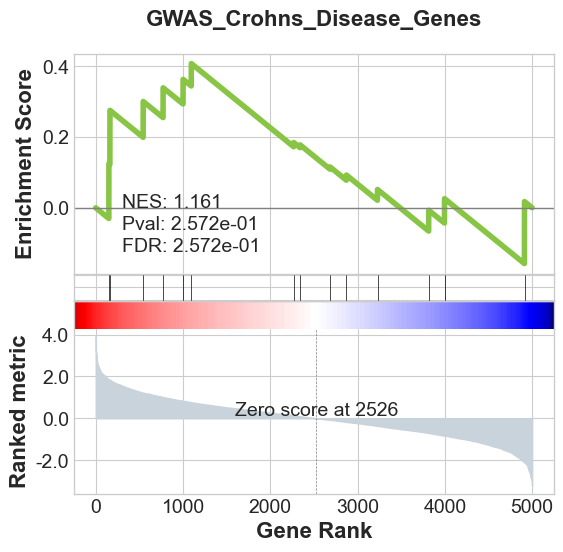

In [35]:
def plot_gsea_enrichment(pre_res):
    """
    Visualize the GSEA enrichment curve.
    
    The enrichment plot shows:
    - Top: Running enrichment score as we walk down the ranked list
    - Middle: "Barcode" showing where gene set members appear
    - Bottom: The ranked metric values
    
    Parameters:
    -----------
    pre_res : gseapy result object
        Output from run_gwas_gsea()
    """
    # Get the term name
    top_term = pre_res.res2d.sort_values('NES', ascending=False)['Term'].values[0]
    
    # Use gseapy's built-in plotting
    gp.plot.gseaplot(
        rank_metric=pre_res.ranking,
        term=top_term,
        ofname=None,
        **pre_res.results[top_term]
    )

# Plot GSEA enrichment curve
print("\nGSEA Enrichment Plot:")
plot_gsea_enrichment(gsea_res)

---

## Exercise 6: Interpret and Summarize GSEA Results

**Background:**

GSEA provides several key metrics for interpretation:

| Metric | Description | Interpretation |
|--------|-------------|----------------|
| **ES** | Enrichment Score | Maximum deviation of running sum from zero |
| **NES** | Normalized ES | ES adjusted for gene set size and permutations |
| **p-value** | Nominal p-value | Statistical significance (uncorrected) |
| **FDR** | False Discovery Rate | Multiple testing corrected significance |
| **Leading Edge** | Core enrichment genes | Genes contributing most to enrichment |

**Leading Edge Genes:**
These are the genes that appear in the ranked list before the point of maximum enrichment. They represent the "core" of the enrichment signal and are often prioritized for follow-up.

**Goals:**
1. Extract and display key GSEA metrics
2. Identify leading edge genes
3. Interpret the biological significance

**Key Concepts:**
- NES interpretation
- FDR correction
- Leading edge analysis

In [36]:
def summarize_gsea_results(pre_res) -> pd.DataFrame:
    """
    Summarize GSEA results for interpretation.
    
    Parameters:
    -----------
    pre_res : gseapy result object
        Output of run_gwas_gsea()
    
    Returns:
    --------
    pd.DataFrame with:
        - NES: Normalized Enrichment Score
        - p-value: Nominal significance
        - FDR: False Discovery Rate
        - Leading edge genes: Core enrichment genes
    """
    res = pre_res.res2d.copy()
    # Select and rename relevant columns
    summary = res[["NES", "FWER p-val", "FDR q-val", "Lead_genes"]].copy()
    summary.columns = ["NES", "p-value", "FDR", "Leading Edge Genes"]
    
    return summary

In [37]:
# Exercise 6: Summarize GSEA results
print("=" * 60)
print("Exercise 6: Interpret and Summarize GSEA Results")
print("=" * 60)

summary = summarize_gsea_results(gsea_res)

print("\n" + "=" * 50)
print("GSEA RESULTS SUMMARY")
print("=" * 50)

# Extract values
nes = summary["NES"].iloc[0]
pval = summary["p-value"].iloc[0]
fdr = summary["FDR"].iloc[0]
lead_genes = summary["Leading Edge Genes"].iloc[0]

print(f"\nNormalized Enrichment Score (NES): {nes:.3f}")
print(f"Nominal p-value: {pval:.4f}")
print(f"FDR q-value: {fdr:.4f}")

# Interpret the result
print("\n" + "-" * 50)
print("INTERPRETATION:")
print("-" * 50)

if nes > 0:
    direction = "UPREGULATED"
    print(f"• GWAS genes tend to be {direction} in disease")
else:
    direction = "DOWNREGULATED" 
    print(f"• GWAS genes tend to be {direction} in disease")

if pval < 0.05:
    print(f"• The enrichment is statistically significant (p < 0.05)")
else:
    print(f"• The enrichment is NOT statistically significant (p ≥ 0.05)")

if fdr < 0.25:
    print(f"• FDR < 0.25: Enrichment passes recommended threshold")
else:
    print(f"• FDR ≥ 0.25: Enrichment may not be robust")

# Count leading edge genes
lead_gene_list = lead_genes.split(",") if lead_genes else []
print(f"\nLeading edge genes: {len(lead_gene_list)} genes")

Exercise 6: Interpret and Summarize GSEA Results

GSEA RESULTS SUMMARY

Normalized Enrichment Score (NES): 1.161
Nominal p-value: 0.1250
FDR q-value: 0.2572

--------------------------------------------------
INTERPRETATION:
--------------------------------------------------
• GWAS genes tend to be UPREGULATED in disease
• The enrichment is NOT statistically significant (p ≥ 0.05)
• FDR ≥ 0.25: Enrichment may not be robust

Leading edge genes: 1 genes


In [38]:
# Display leading edge genes
print("\n" + "=" * 50)
print("LEADING EDGE GENES")
print("=" * 50)
print("\nThese genes contribute most to the enrichment signal:")

if lead_gene_list:
    # Create a nice display
    for i, gene in enumerate(lead_gene_list[:30], 1):  # Show first 30
        print(f"  {i:2d}. {gene.strip()}")
    
    if len(lead_gene_list) > 30:
        print(f"  ... and {len(lead_gene_list) - 30} more genes")
else:
    print("  No leading edge genes identified")


LEADING EDGE GENES

These genes contribute most to the enrichment signal:
   1. TAOK1;EFEMP1;GNA12;HMGA1;ETS1;PLAG1


---

## Exercise 7: Leading Edge Analysis & Protein Interaction Network

**Background:**

Leading edge genes represent the "core" of the enrichment signal. To understand how these genes work together, we can analyze their protein-protein interactions (PPIs). Protein interaction networks reveal:

- **Hub genes**: Highly connected proteins (potential key regulators)
- **Functional modules**: Clusters of interacting proteins (pathways)
- **Potential drug targets**: Well-connected disease genes

**Data Sources:**
- STRING database: Curated and predicted protein interactions
- BioGRID: Experimentally validated interactions

**Goals:**
1. Extract leading edge genes from GSEA
2. Build a protein interaction network
3. Visualize the network with GWAS genes highlighted
4. Identify hub genes and modules

**Key Concepts:**
- Protein interaction networks
- Network topology (degree, centrality)
- Interactive network visualization

In [ ]:
# Exercise 7: Extract leading edge genes
print("=" * 60)
print("Exercise 7: Leading Edge & Network Analysis")
print("=" * 60)

# Extract leading edge genes
leading_edge_str = gsea_res.res2d.iloc[0]["Lead_genes"]
leading_edge = set(gene.strip() for gene in leading_edge_str.split(",")) if leading_edge_str else set()

print(f"\nLeading edge genes: {len(leading_edge)}")
print(f"GWAS genes in leading edge: {len(leading_edge & gwas_genes)}")

In [ ]:
def generate_synthetic_ppi_data(genes: Set[str], 
                                 density: float = 0.1) -> pd.DataFrame:
    """
    Generate synthetic PPI data for demonstration.
    
    In a real analysis, you would use data from STRING or BioGRID.
    
    Parameters:
    -----------
    genes : Set[str]
        Genes to include in the network
    density : float
        Approximate edge density (0-1)
    
    Returns:
    --------
    pd.DataFrame
        Edge list with protein1, protein2, score columns
    """
    np.random.seed(42)
    gene_list = list(genes)
    n = len(gene_list)
    
    edges = []
    for i in range(n):
        for j in range(i+1, n):
            if np.random.random() < density:
                score = np.random.uniform(0.4, 1.0)
                edges.append({
                    "protein1": gene_list[i],
                    "protein2": gene_list[j],
                    "score": score
                })
    
    return pd.DataFrame(edges)


def build_ppi_network(edge_df: pd.DataFrame,
                      genes_of_interest: Set[str],
                      score_threshold: float = 0.7) -> nx.Graph:
    """
    Construct a protein interaction network for genes of interest.
    
    Parameters:
    -----------
    edge_df : pd.DataFrame
        PPI edges with columns: protein1, protein2, score
    genes_of_interest : Set[str]
        Genes to include in the network
    score_threshold : float
        Minimum interaction confidence score (0-1)
    
    Returns:
    --------
    networkx.Graph
        Protein interaction network
    
    Notes:
    ------
    STRING scores range from 0 to 1, where:
    - > 0.9: Highest confidence
    - > 0.7: High confidence
    - > 0.4: Medium confidence
    """
    G = nx.Graph()
    
    # Add edges that pass threshold and involve genes of interest
    for _, row in edge_df.iterrows():
        if row["score"] >= score_threshold:
            if row["protein1"] in genes_of_interest and row["protein2"] in genes_of_interest:
                G.add_edge(row["protein1"], row["protein2"], weight=row["score"])
    
    return G

In [ ]:
# Generate synthetic PPI data (in real analysis, load from STRING/BioGRID)
print("\nBuilding PPI network...")

# Use leading edge genes for network
network_genes = leading_edge if len(leading_edge) > 5 else gwas_genes

# Generate synthetic PPI data
ppi_edges = generate_synthetic_ppi_data(network_genes, density=0.15)
print(f"  Total potential interactions: {len(ppi_edges)}")

# Build filtered network
G = build_ppi_network(ppi_edges, network_genes, score_threshold=0.7)

print(f"\nNetwork Statistics:")
print(f"  Nodes (proteins): {G.number_of_nodes()}")
print(f"  Edges (interactions): {G.number_of_edges()}")

if G.number_of_nodes() > 0:
    print(f"  Network density: {nx.density(G):.4f}")
    
    # Connected components
    components = list(nx.connected_components(G))
    print(f"  Connected components: {len(components)}")
    print(f"  Largest component size: {len(max(components, key=len))}")

In [ ]:
# Analyze network topology
if G.number_of_nodes() > 0:
    print("\n" + "=" * 50)
    print("NETWORK TOPOLOGY ANALYSIS")
    print("=" * 50)
    
    # Calculate degree centrality
    degree_cent = nx.degree_centrality(G)
    
    # Sort by centrality
    sorted_genes = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)
    
    print("\nTop 10 Hub Genes (by degree centrality):")
    print("-" * 40)
    for i, (gene, cent) in enumerate(sorted_genes[:10], 1):
        degree = G.degree(gene)
        gwas_marker = "★" if gene in gwas_genes else " "
        print(f"  {i:2d}. {gwas_marker} {gene:15s} | Degree: {degree:3d} | Centrality: {cent:.3f}")
    
    print("\n  ★ = GWAS-associated gene")

In [ ]:
# Static network visualization with matplotlib
if G.number_of_nodes() > 0 and G.number_of_nodes() < 100:
    plt.figure(figsize=(12, 10))
    
    # Create layout
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # Node colors: red for GWAS genes, blue for others
    node_colors = ['red' if node in gwas_genes else 'lightblue' for node in G.nodes()]
    
    # Node sizes based on degree
    degrees = dict(G.degree())
    node_sizes = [300 + 100 * degrees[node] for node in G.nodes()]
    
    # Draw network
    nx.draw_networkx_edges(G, pos, alpha=0.3, width=1)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=8)
    
    plt.title("Protein Interaction Network of Leading Edge Genes\n(Red = GWAS genes, Size = Degree)", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("Network too large or empty for static visualization")

In [ ]:
def visualize_network_pyvis(G: nx.Graph, 
                            highlight_genes: Set[str] = None,
                            filename: str = "ppi_network.html"):
    """
    Create an interactive network visualization using PyVis.
    
    Parameters:
    -----------
    G : nx.Graph
        Protein interaction network
    highlight_genes : Set[str]
        Genes to highlight (e.g., GWAS genes)
    filename : str
        Output HTML filename
    
    Returns:
    --------
    Interactive HTML network (saved to file)
    """
    if G.number_of_nodes() == 0:
        print("Empty network - nothing to visualize")
        return
    
    # Create PyVis network
    net = Network(
        height="600px",
        width="100%",
        bgcolor="#ffffff",
        font_color="#333333"
    )
    
    # Add nodes with styling
    degrees = dict(G.degree())
    for node in G.nodes():
        color = "#e74c3c" if highlight_genes and node in highlight_genes else "#3498db"
        size = 15 + 3 * degrees[node]
        net.add_node(
            node, 
            label=node, 
            color=color, 
            size=size,
            title=f"{node}\nDegree: {degrees[node]}\nGWAS: {'Yes' if node in highlight_genes else 'No'}"
        )
    
    # Add edges
    for u, v, d in G.edges(data=True):
        weight = d.get("weight", 0.5)
        net.add_edge(u, v, value=weight, title=f"Score: {weight:.2f}")
    
    # Configure physics
    net.set_options("""
    var options = {
        "physics": {
            "forceAtlas2Based": {
                "gravitationalConstant": -50,
                "centralGravity": 0.01,
                "springLength": 100,
                "springConstant": 0.08
            },
            "solver": "forceAtlas2Based"
        }
    }
    """)
    
    net.save_graph(filename)
    print(f"✓ Interactive network saved to: {filename}")
    print("  Open in a web browser to explore the network")

# Create interactive network visualization
if G.number_of_nodes() > 0:
    visualize_network_pyvis(G, highlight_genes=gwas_genes)

---

## Summary & Conclusions

In this laboratory, we performed an integrated analysis of **Crohn's disease** using multiple data types:

### Key Results:

1. **GWAS Analysis** (Exercises 1-2)
   - Retrieved genome-wide significant associations from the GWAS Catalog
   - Extracted candidate genes implicated by genetic variants

2. **RNA-seq Analysis** (Exercises 3-4)
   - Visualized differential expression using volcano plots
   - Created ranked gene lists for enrichment analysis

3. **GSEA Integration** (Exercises 5-6)
   - Tested whether GWAS genes show altered expression in disease
   - Identified leading edge genes contributing to enrichment

4. **Network Analysis** (Exercise 7)
   - Built protein interaction networks from key genes
   - Identified hub genes as potential therapeutic targets

### Biological Insights:

This type of integrative analysis helps:
- **Prioritize candidate genes** from GWAS for functional validation
- **Identify disease mechanisms** through pathway enrichment
- **Discover potential drug targets** via network analysis

### Next Steps:

1. Validate key genes experimentally (knockdown, CRISPR)
2. Perform pathway analysis (KEGG, Reactome)
3. Integrate additional data types (proteomics, metabolomics)
4. Query drug databases for existing compounds targeting hub genes

In [ ]:
# Final summary table
print("\n" + "=" * 60)
print("LABORATORY SUMMARY")
print("=" * 60)

summary_data = {
    "Metric": [
        "Disease/Trait",
        "GWAS Significant SNPs",
        "GWAS Candidate Genes", 
        "RNA-seq Genes Analyzed",
        "Significant DE Genes (p<0.05)",
        "GSEA NES",
        "GSEA p-value",
        "Leading Edge Genes",
        "PPI Network Nodes",
        "PPI Network Edges"
    ],
    "Value": [
        "Crohn's Disease",
        len(gwas_df),
        len(gwas_genes),
        len(de_df),
        (de_df['pvalue'] < 0.05).sum(),
        f"{summary['NES'].iloc[0]:.3f}",
        f"{summary['p-value'].iloc[0]:.4f}",
        len(leading_edge),
        G.number_of_nodes(),
        G.number_of_edges()
    ]
}

summary_table = pd.DataFrame(summary_data)
print(summary_table.to_string(index=False))